**Importing the libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import regularizers

**Loading the File**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving compresive_strength_concrete.csv to compresive_strength_concrete.csv


In [34]:
import io
df= pd.read_csv(io.BytesIO(uploaded["compresive_strength_concrete.csv"]))

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [36]:
df.isnull().sum()

Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)          0
dtype: int64

In [37]:
df[df.duplicated()]

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
77,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
80,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
86,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
91,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
100,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
103,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
111,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
123,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.29


In [38]:
df.drop_duplicates(inplace=True)

In [39]:
len(df)

1005

In [40]:
normalized_data=df.copy()
len(normalized_data)

1005

**Split Traning and Testing data**

In [41]:
normalized_data = normalized_data.sample(frac=1) # Shuffling the data
train_data_full= normalized_data.iloc[:704,:]
test_data_full = normalized_data.iloc[704:, :]
train_data = train_data_full.iloc[:, :-1]
train_labels = train_data_full.iloc[:, -1:]
test_data = test_data_full.iloc[:, :-1]
test_labels = test_data_full.iloc[:, -1:]

In [42]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(704, 8)
(301, 8)
(704, 1)
(301, 1)


In [43]:
train_data.head(3)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
424,173.5,50.1,173.5,164.8,6.5,1006.2,793.5,14
357,277.2,97.8,24.5,160.7,11.2,1061.7,782.5,56
539,480.0,0.0,0.0,192.0,0.0,936.2,712.2,90


In [44]:
train_labels.head(3)

,"Concrete compressive strength(MPa, megapascals)"
424,33.01
357,66.82
539,54.32


In [45]:
test_data.head(3)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
423,172.4,13.6,172.4,156.8,4.1,1006.3,856.4,14
516,202.0,11.0,141.0,206.0,1.7,942.0,801.0,3
551,255.0,0.0,0.0,192.0,0.0,889.8,945.0,3


In [46]:
test_labels.head(3)

,"Concrete compressive strength(MPa, megapascals)"
423,29.75
516,9.85
551,8.20


**Data Normalization**

In [47]:
train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

In [48]:
mean = train_data.mean(axis=0)
train_data -=mean
std =train_data.std(axis=0)
train_data /=std

test_data -=mean
test_data /=std


**Building the Network**

In [49]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(10,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
  model.add(layers.Dense(8,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
  model.add(layers.Dense(6,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
  model.add(layers.Dense(1))
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

**K-Fold Validation**

In [50]:
k= 5
num_val_sample = len(train_data) // k
num_epochs = 90
all_scores = []
all_val_loss_histories = []
all_val_mae_histories = []
all_loss_histories =[]
all_mae_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs, batch_size=4, verbose=1)
  val_loss, val_mae = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_mae_history = history.history["val_mae"]
  loss_history = history.history["loss"]
  mae_history = history.history["mae"]
  all_loss_histories.append(loss_history)
  all_mae_histories.append(mae_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_mae_histories.append(val_mae_history)
  all_scores.append(val_mae)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_mae_hist = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]
ave_mae_hist = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
all_scores

processing fold # 0
Epoch 1/90
141/141 [==============================] - 2s 6ms/step - loss: 1243.1799 - mae: 31.2746 - val_loss: 621.0461 - val_mae: 20.4329
Epoch 2/90
141/141 [==============================] - 0s 2ms/step - loss: 296.9808 - mae: 13.4287 - val_loss: 218.8317 - val_mae: 12.2446
Epoch 3/90
141/141 [==============================] - 0s 2ms/step - loss: 170.3878 - mae: 10.6938 - val_loss: 190.1938 - val_mae: 11.5214
Epoch 4/90
141/141 [==============================] - 0s 2ms/step - loss: 156.0504 - mae: 10.2038 - val_loss: 177.0782 - val_mae: 11.1181
Epoch 5/90
141/141 [==============================] - 0s 2ms/step - loss: 133.6332 - mae: 9.1064 - val_loss: 168.8494 - val_mae: 10.8324
Epoch 6/90
141/141 [==============================] - 0s 2ms/step - loss: 139.0037 - mae: 9.4686 - val_loss: 164.5988 - val_mae: 10.6150
Epoch 7/90
141/141 [==============================] - 0s 2ms/step - loss: 127.5323 - mae: 9.1346 - val_loss: 155.3243 - val_mae: 10.3881
Epoch 8/90
141/1

[4.569997787475586,
 4.415872097015381,
 4.283514499664307,
 4.768832683563232,
 4.3892741203308105]

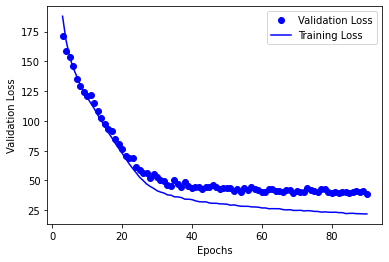

In [51]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[2:], ave_val_loss_hist[2:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[2:], ave_loss_hist[2:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

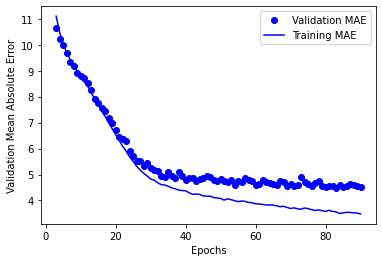

In [52]:
plt.plot(range(1, len(ave_val_mae_hist)+1)[2:], ave_val_mae_hist[2:], "bo", label="Validation MAE")
plt.plot(range(1, len(ave_val_mae_hist)+1)[2:], ave_mae_hist[2:], "b", label="Training MAE")
plt.xlabel("Epochs")
plt.ylabel("Validation Mean Absolute Error")
plt.legend()
plt.show()

**Building The final Network**

In [53]:
# New Model
model = models.Sequential()
model.add(layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
model.add(layers.Dense(6,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

**Compiling the Final Netwrok**

In [54]:
model.fit(train_data, train_labels,batch_size=4, epochs=90)

Epoch 1/90
176/176 [==============================] - 1s 1ms/step - loss: 1385.7482 - mae: 33.3951
Epoch 2/90
176/176 [==============================] - 0s 1ms/step - loss: 294.0770 - mae: 13.7431
Epoch 3/90
176/176 [==============================] - 0s 1ms/step - loss: 175.9769 - mae: 10.8662
Epoch 4/90
176/176 [==============================] - 0s 1ms/step - loss: 154.1305 - mae: 10.3216
Epoch 5/90
176/176 [==============================] - 0s 1ms/step - loss: 145.5928 - mae: 9.5482
Epoch 6/90
176/176 [==============================] - 0s 1ms/step - loss: 115.6727 - mae: 8.6728
Epoch 7/90
176/176 [==============================] - 0s 1ms/step - loss: 118.4776 - mae: 8.8486
Epoch 8/90
176/176 [==============================] - 0s 1ms/step - loss: 107.2564 - mae: 8.1251
Epoch 9/90
176/176 [==============================] - 0s 1ms/step - loss: 104.8981 - mae: 8.1140
Epoch 10/90
176/176 [==============================] - 0s 1ms/step - loss: 92.0561 - mae: 7.5255
Epoch 11/90
176/176 [====

**Evaluating the Network**

In [55]:
test_mse_scoe, test_mae_score=model.evaluate(test_data, test_labels)

10/10 [==============================] - 0s 1ms/step - loss: 33.6748 - mae: 4.3654


In [56]:
test_mae_score

4.365358829498291

**Predicting the values**

In [57]:
denormalized = test_labels

In [58]:
prediction=model.predict(test_data)

In [59]:
pred_norm=prediction

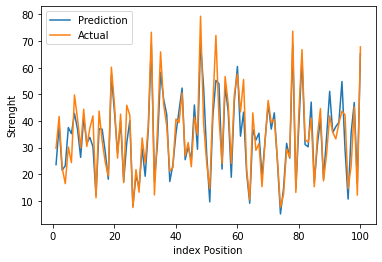

In [63]:
plt.plot(range(1, len(pred_norm[:300:3])+1), pred_norm[:300:3], label="Prediction")
plt.plot(range(1, len(pred_norm[:300:3])+1), denormalized[:300:3], label="Actual")
plt.xlabel("index Position")
plt.ylabel("Strenght")
plt.legend()
plt.show()


In [64]:
denormalized[20:30]

array([[53.96],
       [40.68],
       [47.81],
       [29.  ],
       [29.89],
       [36.56],
       [31.65],
       [44.4 ],
       [24.92],
       [11.96]])

In [65]:
pred_norm[20:30]

array([[51.24862 ],
       [36.809513],
       [43.859695],
       [35.68862 ],
       [26.353813],
       [29.308052],
       [31.15794 ],
       [41.33503 ],
       [22.943466],
       [12.347937]], dtype=float32)